# 3-1. 聚类

## 1. 背景

在前面的分析中，我们已经完成了单细胞测序数据的预处理，包括质控，归一化，高可变基因计算，降维，可视化。我们已经可以简单地去评估我们单细胞数据的质量以及一些基本属性。但是，这并不是我们单细胞分析的目的，单细胞测序数据经过预处理后，下一步是在数据集中识别细胞结构。

> 细胞结构
> 
> 我们一般认为不同种类的细胞具有不通的细胞结构，我们可以将相似的细胞聚类到一起，进而寻找相似的细胞中的共同特征，如：共同表达的基因，细胞的基因分布。我们基于细胞的共同特征，为细胞赋予不同的身份。寻找相似的细胞结构的过程被称为“聚类”。

> 聚类
> 
> 字面含义：聚集为同一种类。这是机器学习中的一个常见的问题。一般分为有监督聚类和无监督聚类两种模型，两种模型在单细胞数据中均有一定的应用，而在本章中，我们主要介绍的是无监督聚类。

我们首先计算了单细胞测序数据中的邻域图，我们使用KNN最近邻算法进行计算，一般来说，我们会使用细胞的主成分(PCA)来作为细胞的特征向量，然后基于细胞的特征向量来构建KNN图。不过，邻域图的构建并不绝对依赖于PCA，我们也可以使用别的算法来计算细胞的特征向量，如`scvi-tools`的latent空间`X_scVI`，如`GLUE`的细胞低维表示`X_glue`等，所以KNN图的计算是很灵活的。

> KNN图
> 
> KNN图中，节点反映了数据集中的细胞。我们首先在经过主成分降维的表达空间上计算所有细胞之间的欧氏距离矩阵，然后将每个细胞连接到其K个最相似的细胞。通常，根据数据集的大小，K的值设置在5到100之间。KNN图通过将表达空间中的密集区域表示为图中的密集连接区域，反映了表达数据的潜在拓扑结构。

在获得细胞的邻域图后，我们可以根据细胞的图结构，利用图聚类算法，将相似的细胞聚类到一起。在单细胞测序中，我们一般会使用`Leiden`或者`Louvain`算法来对单细胞数据进行聚类。由于`Louvain`算法不再维护了，所以我们一般推荐使用`Leiden`算法。Leiden算法通过考虑聚类中细胞之间的连接数与数据集中整体预期连接数之间的比例来创建聚类。


<img src="https://www.sc-best-practices.org/_images/clustering.jpeg" alt="Clustering Overview" class="bg-primary mb-1" width="800px">

Leiden算法在从经过主成分降维的表达空间中获取的KNN图上进行聚类计算。它从初始分区开始，其中每个节点都属于自己的社区。接下来，算法将单个节点从一个社区移动到另一个社区，以找到一个分区，然后进行细化。基于细化后的分区，生成一个聚合网络，再次进行细化，直到无法进一步改进，达到最终分区。

起始点是一个单节点分区，其中每个节点都作为自己的社区（a）。然后，算法通过将单个节点从一个社区移动到另一个社区来创建分区（b），然后进行细化以增强分区（c）。细化后的分区随后聚合成一个网络（d）。然后，算法再次在聚合网络中移动单个节点（e），直到细化不再改变分区（f）。所有步骤都重复进行，直到创建出最终的聚类，并且分区不再改变。

Leiden模块具有分辨率参数，可以确定分区簇的规模，从而确定聚类的粗细程度。较高的分辨率参数会导致更多的聚类。该算法还允许通过对KNN图进行子集操作，在数据集中有效地进行特定聚类的子聚类。子聚类使用户能够在聚类中识别细胞类型特定的状态，或进行更精细的细胞类型标记[wagner_revealing_2016]，但也可能导致仅由数据中存在的噪声引起的模式。

正如前面提到的，Leiden算法已在scanpy中实现。

In [1]:
import omicverse as ov
print(f'omicverse version: {ov.__version__}')
import scanpy as sc
print(f'scanpy version: {sc.__version__}')
ov.ov_plot_set()

omicverse version: 1.4.13
scanpy version: 1.7.2


## 2. 对人类骨髓细胞进行聚类

我们将使用上一章预处理降维后所得到的文件进行聚类分析，该数据集已经经过移位对数归一化，高可变基因的筛选，还有主成分分析（PCA）。


In [2]:
adata = ov.read('../preprocess/s4d8_dimensionality_reduction.h5ad')
adata

AnnData object with n_obs × n_vars = 14814 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'log2_nUMIs', 'log2_nGenes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'counts|original|cum_sum_eigenvalues', 'counts|original|pca_var_ratios', 'hvg', 'layers_counts', 'log1p', 'neighbors', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'tsne', 'umap'
    obsm: '

我们首先基于细胞的主成分`scaled|original|X_pca`构建邻域图，在`scanpy`中，KNN邻域图的构建是通过`scanpy.pp.neighbors`函数来完成的，我们首先选择前30个主成分来构建邻域图，通常认为前30个主成分已经捕获了数据中的绝大多数方差。不过也不绝对，在一些分析中也会设定为前50个主成分，或者前100个主成分。这取决于你的分析目的是否会受微小方差的影响。

In [3]:
sc.pp.neighbors(adata, n_neighbors=15,
                n_pcs=30,use_rep='scaled|original|X_pca')

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


我们现在可以调用Leiden算法。

In [4]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


在scanpy中，默认的分辨率参数为1.0。然而，在许多情况下，分析师可能希望尝试不同的分辨率参数来控制聚类的粗细程度。因此，我们建议将聚类结果保存在指定的键下，以指示所选的分辨率。

In [5]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2.0)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0_25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_res0_5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden_res1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden_res2', the cluster labels (adata.obs, categorical) (0:00:01)


我们现在可视化使用Leiden算法在不同分辨率下获得的不同聚类结果。正如我们所看到的，分辨率严重影响我们聚类的粗细程度。更高的分辨率参数会导致更多的社区，即更多的识别出的聚类，而更低的分辨率参数会导致更少的社区。因此，分辨率参数控制算法如何将knn嵌入中的密集聚类区域组合在一起。这将在注释聚类时变得尤为重要。

[<AxesSubplot: title={'center': 'Resolution:0.25'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'Resolution:0.5'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'Resolution:1'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'Resolution:2'}, xlabel='X_mde1', ylabel='X_mde2'>]

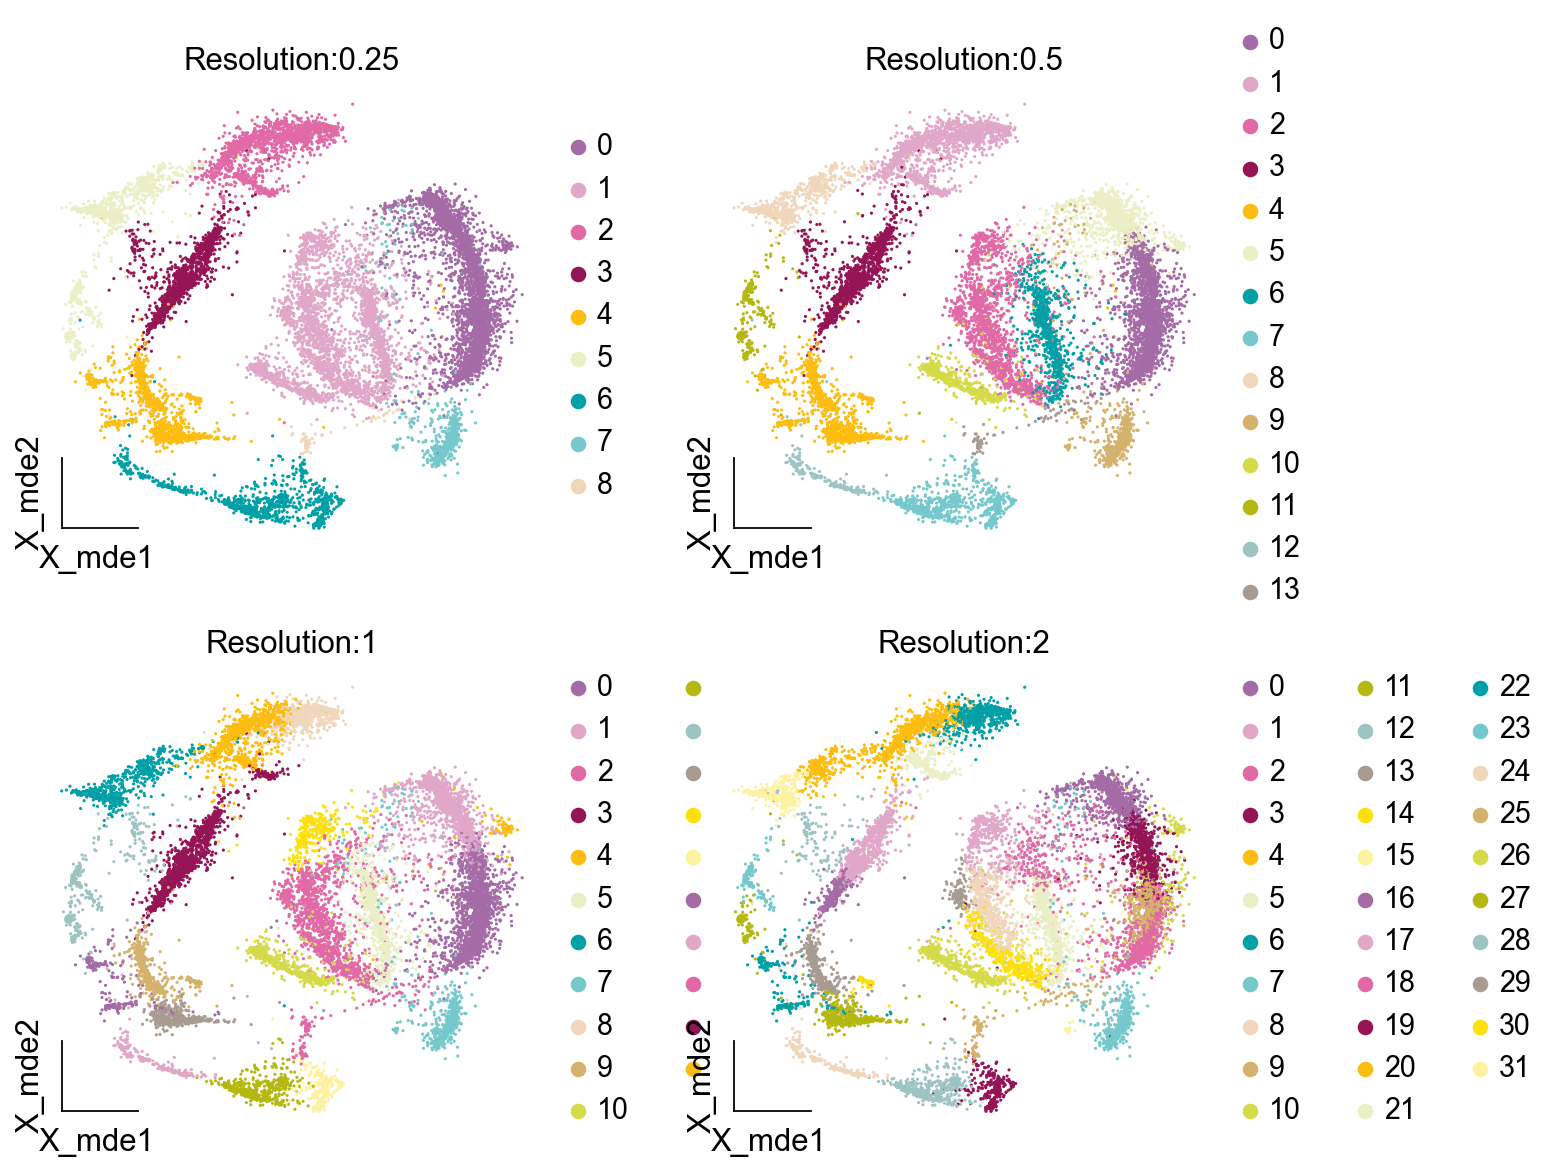

In [7]:
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

ov.utils.embedding(adata,
                basis='X_mde',
                color=["leiden_res0_25", "leiden_res0_5", "leiden_res1","leiden_res2"],
                title=['Resolution:0.25','Resolution:0.5','Resolution:1','Resolution:2'],
                palette=ov.palette()[12:],
                ncols=2,
                show=False,frameon='small',)

我们现在清楚地检查了不同分辨率对聚类结果的影响。对于分辨率为0.25的情况，聚类要粗糙得多，算法检测到的社区更少。此外，与分辨率为1.0的聚类相比，聚类区域更少密集。

我们再次强调，显示的聚类之间的距离必须谨慎解释。由于UMAP嵌入是2D的，因此并不一定能够很好地捕捉所有点之间的距离。我们建议不要在UMAP嵌入上解释聚类之间的距离。如果真要计算细胞之间的相似性，可以使用PCA嵌入来解释。

## 3. 思考

- 我们为什么要计算KNN邻域图？能不能用别的方法来替代这一步？
- Leiden是一种无监督聚类算法，那么你知道单细胞测序中的有监督聚类算法有哪些吗？
- 分辨率不同会对聚类结果有什么影响？我们该怎么选择合适的分辨率？